In [ ]:
!pwd

/content


### Load drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Import necessary libraries

In [3]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

### Combined Dataset (from Feature-specific CSVs)

In [4]:
# Folder paths
none_folder = "/content/drive/MyDrive/BAP/features_none"
both_folder = "/content/drive/MyDrive/BAP/features_both"

# Electrode names
channel_names = [
    'Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3',
    'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1',
    'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Oz', 'POz', 'Pz',
    'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6',
    'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'C6',
    'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10',
    'PO8', 'PO4', 'O2'
]

# Process individual folders
def load_features(folder, group_label):
    all_data = []  # To store all processed files
    for file in sorted(os.listdir(folder)):
        if file.endswith('.csv'):
            # Load the file with the first row as column headers
            file_path = os.path.join(folder, file)
            df = pd.read_csv(file_path, header=0, skiprows=[1])  # Skip the second row containing metadata

            # Assign electrode names to rows
            df.index = channel_names

            # Drop columns
            df = df.drop(columns=["row", "sampEn", "cv", "rms", "variance"], errors="ignore")

            # Extract patient identifier from the file name
            patient_id = file.replace('.csv', '')  # Get file name without extension

            # Add patient and group information
            df['Patient'] = patient_id  # Add patient identifier
            df['Group'] = group_label  # Add group label (0 for none, 1 for both)

            # Reset index to include electrode names as a column
            df = df.reset_index().rename(columns={'index': 'Electrode'})

            # Append to list
            all_data.append(df)

    # Combine all data from this folder
    combined_data = pd.concat(all_data, ignore_index=True)
    return combined_data

# Process both folders
none_data = load_features(none_folder, group_label=0)  # Group 0 = "none"
both_data = load_features(both_folder, group_label=1)  # Group 1 = "both"

# Combine both datasets
all_features = pd.concat([none_data, both_data], ignore_index=True)

# Save the combined dataset
all_features.to_csv("/content/drive/MyDrive/BAP/combined_features.csv", index=False)

# Display combined dataset structure
print(all_features.info())
print(all_features.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4032 entries, 0 to 4031
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Electrode  4032 non-null   object 
 1   mean       4032 non-null   float64
 2   skewness   4032 non-null   float64
 3   kurtosis   4032 non-null   float64
 4   std        4032 non-null   float64
 5   median     4032 non-null   float64
 6   zcr        4032 non-null   float64
 7   p2p        4032 non-null   float64
 8   Patient    4032 non-null   object 
 9   Group      4032 non-null   int64  
dtypes: float64(7), int64(1), object(2)
memory usage: 315.1+ KB
None
  Electrode          mean  skewness  kurtosis       std    median       zcr  \
0       Fp1 -4.020306e-18 -0.168919  0.309165  0.116039  0.003580  0.150418   
1       AF7 -1.855526e-18  0.034673  0.713462  0.118277  0.005634  0.142061   
2       AF3  6.185086e-18 -0.171996 -0.185863  0.122166 -0.000141  0.122563   
3        F1 -2.474035e-18 -0

### Feature correlation matrices

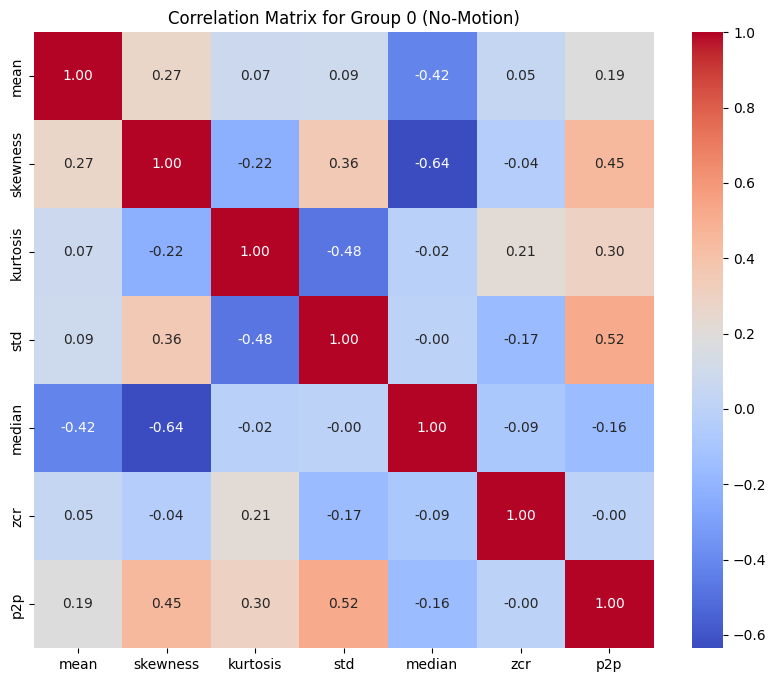

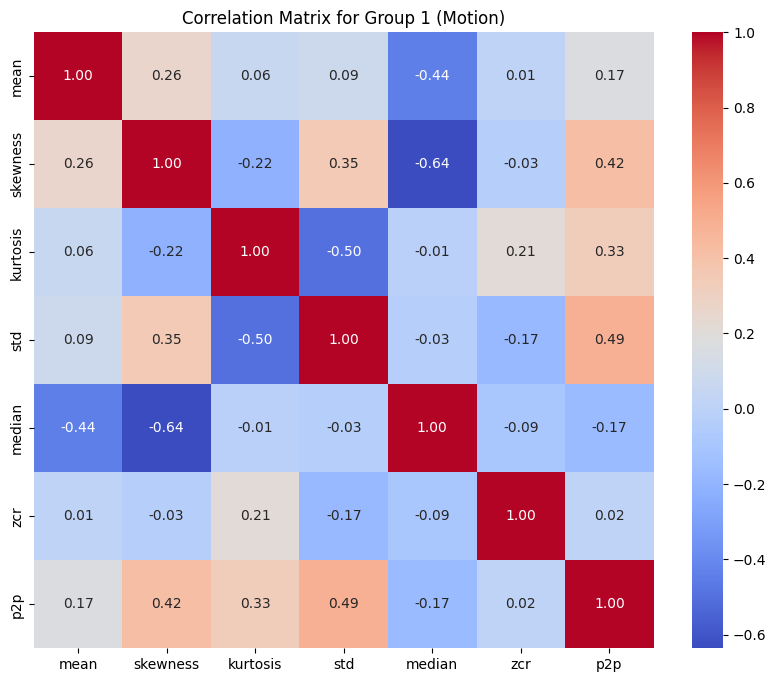

In [5]:
# Load the combined dataset
file_path = "/content/drive/MyDrive/BAP/combined_features.csv"
combined_features = pd.read_csv(file_path)

# Split the dataset by Group
group_0 = combined_features[combined_features['Group'] == 0]
group_1 = combined_features[combined_features['Group'] == 1]

# Drop non-numeric and grouping columns for correlation analysis
correlation_features_0 = group_0.drop(columns=['Group', 'Electrode', 'Patient'], errors='ignore')
correlation_features_1 = group_1.drop(columns=['Group', 'Electrode', 'Patient'], errors='ignore')

# Calculate correlation matrices
correlation_matrix_0 = correlation_features_0.corr()
correlation_matrix_1 = correlation_features_1.corr()

# Save the correlation matrices
correlation_matrix_0.to_csv("/content/drive/MyDrive/BAP/combined_correlation_matrix_group_0.csv")
correlation_matrix_1.to_csv("/content/drive/MyDrive/BAP/combined_correlation_matrix_group_1.csv")

# Plot the heatmaps
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_0, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix for Group 0 (No-Motion)")
plt.show()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_1, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix for Group 1 (Motion)")
plt.show()

Correlation Matrices insights:

    Features like p2p, std, and skewness exhibit strong relationships with other features, making them crucial for capturing group-level variance.
    zcr shows minimal correlation with other features, suggesting it may contribute independent information or could be deprioritized.

###ANOVA to the Combined Dataset (7 features selected - 'mean', 'median', 'p2p', 'skewness', 'std', 'zcr', 'kurtosis')

In [6]:
from scipy.stats import f_oneway

# Load the combined dataset
file_path = "/content/drive/MyDrive/BAP/combined_features.csv"
combined_features = pd.read_csv(file_path)

# Features to analyze
features = ['mean', 'median', 'p2p', 'skewness', 'std', 'zcr', 'kurtosis']

# Initialize a dictionary to store ANOVA results for each feature
anova_results = {feature: [] for feature in features}

# Perform ANOVA for each feature across electrodes
for feature in features:
    unique_electrodes = combined_features['Electrode'].unique()
    for electrode in unique_electrodes:
        # Subset the data for the current electrode
        electrode_data = combined_features[combined_features['Electrode'] == electrode]

        # Extract feature values for the two groups
        group_0 = electrode_data[electrode_data['Group'] == 0][feature]
        group_1 = electrode_data[electrode_data['Group'] == 1][feature]

        # Perform ANOVA if both groups have sufficient data
        if len(group_0) > 1 and len(group_1) > 1:
            f_stat, p_value = f_oneway(group_0, group_1)
        else:
            f_stat, p_value = np.nan, np.nan  # Not enough data for ANOVA

        # Append the results
        anova_results[feature].append({
            "Electrode": electrode,
            "F-Statistic": f_stat,
            "P-Value": p_value
        })

# Convert results to DataFrames for each feature
result_dfs = {feature: pd.DataFrame(results) for feature, results in anova_results.items()}

# Save the results to CSV files (optional)
for feature, df in result_dfs.items():
    df.to_csv(f"/content/drive/MyDrive/BAP/anova_all_results_{feature}.csv", index=False)

# Display significant electrodes for each feature
for feature, df in result_dfs.items():
    print(f"Significant electrodes for {feature} (P < 0.05):")
    significant = df[df['P-Value'] < 0.05]
    print(significant)

Significant electrodes for mean (P < 0.05):
   Electrode  F-Statistic   P-Value
43       FC4     6.836854  0.011196
Significant electrodes for median (P < 0.05):
   Electrode  F-Statistic   P-Value
11        C1     4.015102  0.049469
31       Fpz     5.014912  0.028727
56        P4     4.496939  0.037963
Significant electrodes for p2p (P < 0.05):
   Electrode  F-Statistic   P-Value
39        F6     6.215298  0.015349
40        F8     4.499850  0.037903
62        O2     6.213026  0.015367
Significant electrodes for skewness (P < 0.05):
   Electrode  F-Statistic   P-Value
54       CP2     4.326212  0.041670
56        P4     9.780432  0.002686
Significant electrodes for std (P < 0.05):
   Electrode  F-Statistic   P-Value
4         F3    11.291396  0.001337
8        FC5     4.350534  0.041119
13        C5     5.888120  0.018164
30       CPz     4.589412  0.036105
38        F4     4.860201  0.031203
62        O2     6.907515  0.010806
Significant electrodes for zcr (P < 0.05):
   Electrode 

### Post-ANOVA analysis and evaluation (tables, plots, effect size, permutation test)

In [7]:
!pip install -U kaleido

SIGNIFICANT ELECTRODES PER FEATURE TABLE

In [8]:
import plotly.graph_objects as go

# Load ANOVA results
file_paths = {
    'mean': "/content/drive/MyDrive/BAP/anova_all_results_mean.csv",
    'median': "/content/drive/MyDrive/BAP/anova_all_results_median.csv",
    'p2p': "/content/drive/MyDrive/BAP/anova_all_results_p2p.csv",
    'skewness': "/content/drive/MyDrive/BAP/anova_all_results_skewness.csv",
    'std': "/content/drive/MyDrive/BAP/anova_all_results_std.csv",
    'zcr': "/content/drive/MyDrive/BAP/anova_all_results_zcr.csv",
    'kurtosis': "/content/drive/MyDrive/BAP/anova_all_results_kurtosis.csv",
}

# Load significant electrodes for each feature
significant_data = {}
for feature, path in file_paths.items():
    df = pd.read_csv(path)
    significant = df[df['P-Value'] < 0.05]
    significant_data[feature] = significant['Electrode'].tolist()

# Combine significant electrodes into one table
combined_significant = pd.DataFrame(columns=['Electrode'])
for feature, electrodes in significant_data.items():
    combined_significant = pd.concat([combined_significant, pd.DataFrame({'Electrode': electrodes})])

# Drop duplicates and reset index
combined_significant = combined_significant.drop_duplicates().reset_index(drop=True)

# Add columns for each feature
for feature in file_paths.keys():
    combined_significant[feature] = combined_significant['Electrode'].apply(
        lambda x: '✓' if x in significant_data[feature] else ''
    )

# Prepare the data for the interactive table
table_data = {
    "Electrode": combined_significant['Electrode']
}
for feature in file_paths.keys():
    table_data[feature.capitalize()] = combined_significant[feature]

# Create the interactive table
fig = go.Figure(data=[go.Table(
    header=dict(
        values=['<b>Electrode</b>'] + [f'<b>{feature.capitalize()}</b>' for feature in file_paths.keys()],
        fill_color='#B0E0E6',
        align='center',
        font=dict(color='black', size=12)
    ),
    cells=dict(
        values=[table_data[column] for column in table_data],
        fill_color='#F5F5F5',
        align='center',
        font=dict(color='black', size=11)
    )
)])

# Export to PNG for use in static documents
fig.write_image("/content/drive/MyDrive/BAP/significant_electrodes_table.png")

# Display the table
fig.show()

HEATMAP

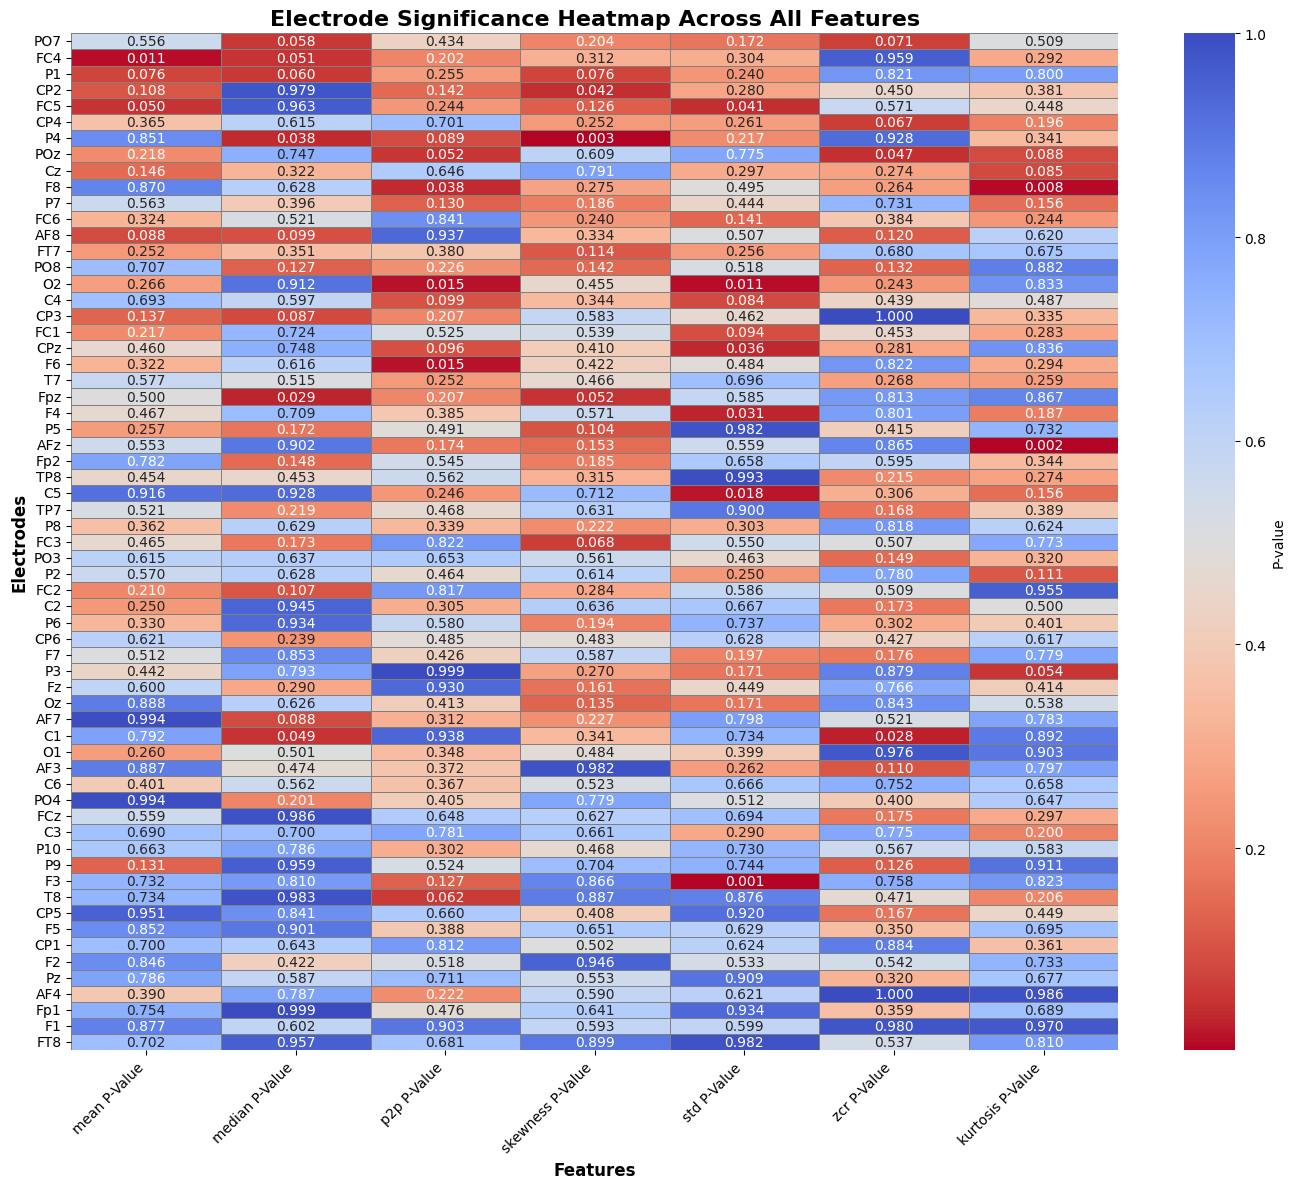

In [10]:
# Create a DataFrame for the heatmap with all 7 features
heatmap_data = pd.DataFrame({
    "Electrode": result_dfs["mean"]["Electrode"],
    "mean P-Value": result_dfs["mean"]["P-Value"],
    "median P-Value": result_dfs["median"]["P-Value"],
    "p2p P-Value": result_dfs["p2p"]["P-Value"],
    "skewness P-Value": result_dfs["skewness"]["P-Value"],
    "std P-Value": result_dfs["std"]["P-Value"],
    "zcr P-Value": result_dfs["zcr"]["P-Value"],
    "kurtosis P-Value": result_dfs["kurtosis"]["P-Value"]
}).set_index("Electrode")

# Remove rows with all NaN P-Values (electrodes that were not significant for any feature)
heatmap_data_cleaned = heatmap_data.dropna(how='all')

# Sort rows by average P-Value (optional)
heatmap_data_cleaned["Average P-Value"] = heatmap_data_cleaned.mean(axis=1)
heatmap_data_cleaned = heatmap_data_cleaned.sort_values("Average P-Value").drop(columns=["Average P-Value"])

# Create the heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(
    heatmap_data_cleaned,
    annot=True,
    fmt=".3f",
    cmap="coolwarm_r",
    cbar_kws={'label': 'P-value'},
    linewidths=0.5,
    linecolor='gray'
)
plt.title("Electrode Significance Heatmap Across All Features", fontsize=16, fontweight="bold")
plt.ylabel("Electrodes", fontsize=12, fontweight='bold')
plt.xlabel("Features", fontsize=12, fontweight='bold')
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

# Save the heatmap
plt.savefig("/content/drive/MyDrive/BAP/electrode_significance_heatmap.png", dpi=300)

# Show the heatmap
plt.show()

BAR PLOT

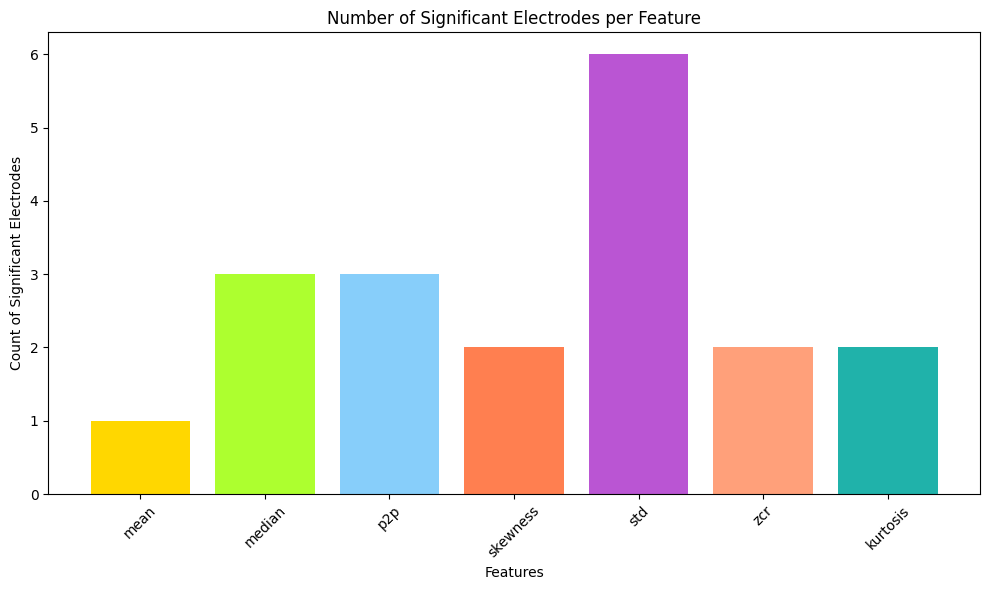

In [ ]:
# Count significant electrodes per feature
significant_counts = [len(significant_data[feature]) for feature in file_paths.keys()]

# Plot grouped bar chart
plt.figure(figsize=(10, 6))
plt.bar(file_paths.keys(), significant_counts, color=['#FFD700', '#ADFF2F', '#87CEFA', '#FF7F50', '#BA55D3', '#FFA07A', '#20B2AA'])
plt.title("Number of Significant Electrodes per Feature")
plt.xlabel("Features")
plt.ylabel("Count of Significant Electrodes")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/BAP/significant_electrodes_barplot.png")
plt.show()

ELECTRODE-FEATURE SIGNIFICANCE NETWORK

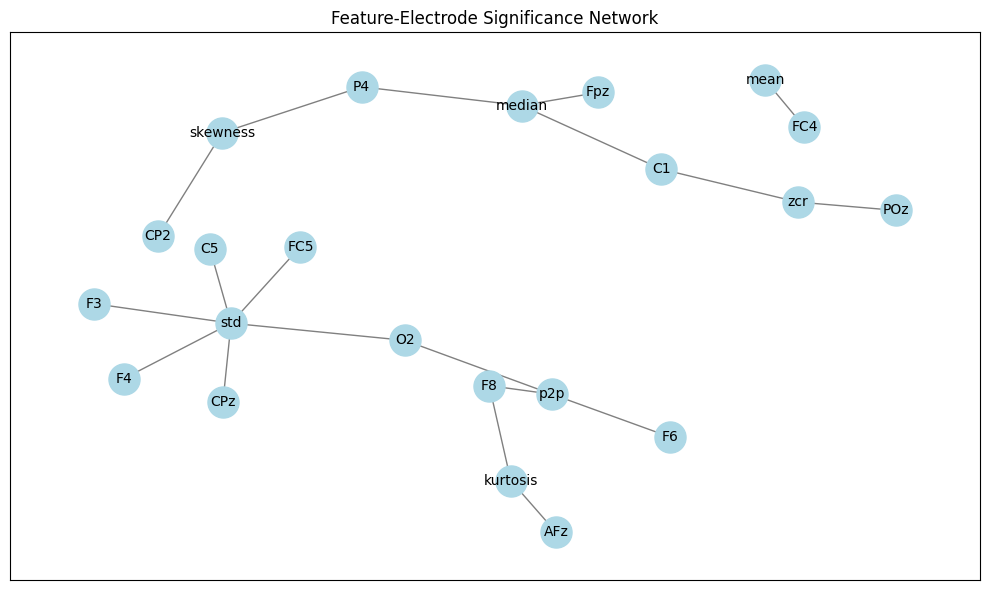

In [20]:
import networkx as nx

# Create a graph
G = nx.Graph()

# Add nodes for features and electrodes
G.add_nodes_from(file_paths.keys(), bipartite=0)  # Features
G.add_nodes_from(combined_significant['Electrode'], bipartite=1)  # Electrodes

# Add edges for significant electrodes
for feature, electrodes in significant_data.items():
    for electrode in electrodes:
        G.add_edge(feature, electrode)

# Adjust the layout
pos = nx.spring_layout(G, k=0.5)
plt.figure(figsize=(10, 6))
nx.draw_networkx_nodes(G, pos, node_color="lightblue", node_size=500)
nx.draw_networkx_edges(G, pos, edge_color="gray")
nx.draw_networkx_labels(G, pos, font_size=10)
plt.title("Feature-Electrode Significance Network")
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/BAP/anova_network_adjusted.png")
plt.show()

RADAR CHART

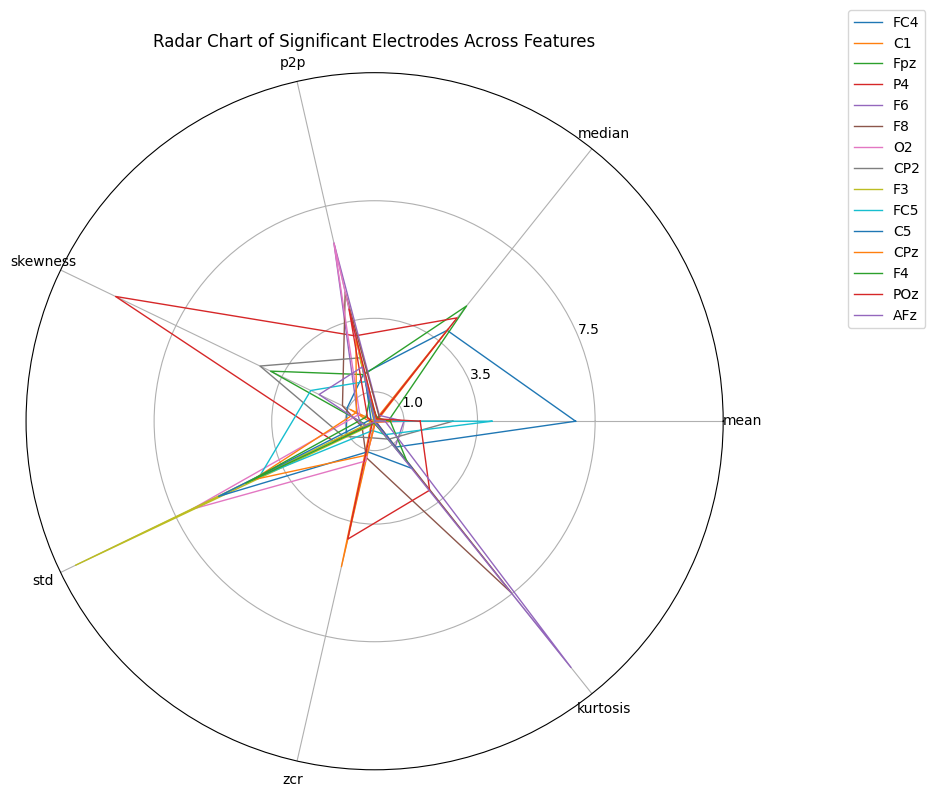

In [ ]:
# Prepare data for radar chart
radar_data = {electrode: [] for electrode in combined_significant['Electrode']}
for feature in file_paths.keys():
    feature_df = pd.read_csv(file_paths[feature])
    for electrode in radar_data.keys():
        value = feature_df.loc[feature_df['Electrode'] == electrode, 'F-Statistic']
        radar_data[electrode].append(value.values[0] if not value.empty else 0)

# Create radar chart
features = list(file_paths.keys())
angles = np.linspace(0, 2 * np.pi, len(features), endpoint=False).tolist()
angles += angles[:1]  # Close the circle

plt.figure(figsize=(10, 8))
ax = plt.subplot(111, polar=True)

# Plot each electrode's line
for electrode, values in radar_data.items():
    values += values[:1]  # Close the circle
    ax.plot(angles, values, linewidth=1, linestyle='solid', label=electrode)

ax.set_yticks([1.0, 3.5, 7.5])
ax.set_xticks(angles[:-1])
ax.set_xticklabels(features)
plt.title("Radar Chart of Significant Electrodes Across Features")
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/BAP/significant_electrodes_radar.png")
plt.show()

EFFECT SIZES CALCULATION

In [ ]:
# Function to calculate Cohen's d
def cohen_d(group1, group2):
    n1, n2 = len(group1), len(group2)
    mean1, mean2 = np.mean(group1), np.mean(group2)
    var1, var2 = np.var(group1, ddof=1), np.var(group2, ddof=1)
    pooled_sd = np.sqrt(((n1 - 1) * var1 + (n2 - 1) * var2) / (n1 + n2 - 2))
    return (mean1 - mean2) / pooled_sd

# Calculate effect sizes for significant electrodes
effect_sizes = []
for feature, df in result_dfs.items():
    significant_electrodes = df[df['P-Value'] < 0.05]['Electrode']
    for electrode in significant_electrodes:
        data = combined_features[combined_features['Electrode'] == electrode]
        group1 = data[data['Group'] == 0][feature]
        group2 = data[data['Group'] == 1][feature]
        d = cohen_d(group1, group2)
        effect_sizes.append({'Feature': feature, 'Electrode': electrode, 'Effect Size (d)': d})

# Convert results to a DataFrame
effect_sizes_df = pd.DataFrame(effect_sizes)
print(effect_sizes_df)

# Save results
effect_sizes_df.to_csv("/content/drive/MyDrive/BAP/effect_sizes.csv", index=False)

     Feature Electrode  Effect Size (d)
0       mean       FC4        -0.653684
1     median        C1         0.500943
2     median       Fpz        -0.559850
3     median        P4         0.530150
4        p2p        F6        -0.623262
5        p2p        F8         0.530321
6        p2p        O2        -0.623149
7   skewness       CP2        -0.519989
8   skewness        P4        -0.781842
9        std        F3        -0.840067
10       std       FC5        -0.521448
11       std        C5         0.606636
12       std       CPz        -0.535573
13       std        F4        -0.551147
14       std        O2        -0.657054
15       zcr        C1         0.563082
16       zcr       POz        -0.507033
17  kurtosis       AFz         0.818344
18  kurtosis        F8         0.683711


Insights from Effect Size Calculations:

    Electrode-Specific Findings:
        Some electrodes (e.g., P4, F8, O2) appear significant across multiple features, indicating they are likely to be key regions of interest.
        Features like kurtosis and std seem to capture distinct patterns at different electrodes.

PERMUTATION TEST

In [ ]:
# Permutation test
def permutation_test(data, feature, electrode, num_permutations=1000):
    observed_data = data[data['Electrode'] == electrode]
    group1 = observed_data[observed_data['Group'] == 0][feature]
    group2 = observed_data[observed_data['Group'] == 1][feature]
    observed_stat, _ = f_oneway(group1, group2)

    # Permute labels
    combined = np.concatenate([group1, group2])
    null_dist = []
    for _ in range(num_permutations):
        np.random.shuffle(combined)
        shuffled_group1 = combined[:len(group1)]
        shuffled_group2 = combined[len(group1):]
        perm_stat, _ = f_oneway(shuffled_group1, shuffled_group2)
        null_dist.append(perm_stat)

    # Calculate p-value
    p_value = np.sum(np.array(null_dist) >= observed_stat) / num_permutations
    return observed_stat, p_value

# Run permutation testing for significant electrodes
perm_results = []
for feature, df in result_dfs.items():
    significant_electrodes = df[df['P-Value'] < 0.05]['Electrode']
    for electrode in significant_electrodes:
        stat, p_value = permutation_test(combined_features, feature, electrode)
        perm_results.append({'Feature': feature, 'Electrode': electrode,
                             'Observed F-Statistic': stat, 'Permutation P-Value': p_value})

# Convert results to a DataFrame
perm_results_df = pd.DataFrame(perm_results)
print(perm_results_df)

# Save results
perm_results_df.to_csv("/content/drive/MyDrive/BAP/permutation_results.csv", index=False)

     Feature Electrode  Observed F-Statistic  Permutation P-Value
0       mean       FC4              6.836854                0.010
1     median        C1              4.015102                0.044
2     median       Fpz              5.014912                0.034
3     median        P4              4.496939                0.039
4        p2p        F6              6.215298                0.010
5        p2p        F8              4.499850                0.035
6        p2p        O2              6.213026                0.011
7   skewness       CP2              4.326212                0.040
8   skewness        P4              9.780432                0.005
9        std        F3             11.291396                0.001
10       std       FC5              4.350534                0.048
11       std        C5              5.888120                0.017
12       std       CPz              4.589412                0.036
13       std        F4              4.860201                0.028
14       s

Insights from Permutation Testing:

    Electrode-Specific Patterns:
        Permutation testing reaffirms the importance of electrodes like P4, F8, O2, AFz, and F6 for their respective features, indicating these are consistent regions of interest.